In [1]:
import sys
sys.path.insert(0, "../code")

from config import get_config
cfg, _ = get_config()

cfg.gpu_id = "1,2"
cfg.reward_type = "linear_clipping"
cfg.environment_type = "large"
cfg.train_goal_duration = 20
cfg.train_code_arity = 128
cfg.train_iterations = 100000 # 40000000
cfg.train_bonus_weight = 0
cfg.disable_ensemble = True
cfg.train_seed = 1
cfg.plot_state_occupancies_freq = 100000

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]=str(cfg.gpu_id)

In [3]:
#@title Imports
import functools
import dataclasses
import datetime
import math
import operator
import sys

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
from typing import Dict, List, NewType, Optional, Tuple, TypeVar, Union
from typing_extensions import Protocol
try:
  import chex
except ImportError:
  get_ipython().system('pip install git+https://github.com/deepmind/chex.git@v0.1.3')
  import chex
try:
  import haiku as hk
except ImportError:
  get_ipython().system('pip install git+https://github.com/deepmind/dm-haiku.git@v0.0.6')
  import haiku as hk
try:
  import optax
except ImportError:
  get_ipython().system('pip install git+https://github.com/deepmind/optax.git@v0.1.2')
  import optax
try:
  import rlax
except ImportError:
  get_ipython().system('pip install git+https://github.com/deepmind/rlax.git@b652c45382605d3bf2c7db837364deda19819fce')
  import rlax


try:
  import jax.tools.colab_tpu
  try:
    jax.tools.colab_tpu.setup_tpu()
  except KeyError:  # Not on a TPU Colab backend.
    pass
except ImportError:
  pass

In [4]:
Actions = NewType('Actions', chex.Array)
States = NewType('States', chex.Array)
LatentCodes = NewType('LatentCodes', chex.Array)
LatentLogProbs = NewType('LatentLogProbs', chex.Array)
QValues = NewType('QValues', chex.Array)


class Policy(Protocol):
  """Interface for an (unconditional) policy."""
  def __call__(self, rng_key: chex.PRNGKey, states: States) -> Actions:
    """Generate an action from the environment state and an RNG state.

    Args:
      rng_key: PRNGKey to use for any stochasticity in action selection.
      states: A batch of environment states.
    Returns:
      A batch of integer actions, with shape equal to `states.shape[:-1]`.
    """


@chex.dataclass(frozen=True)
class Unroll:
  """The result of unrolling environment dynamics according to a policy.

  `states` is expected to have one more element along its leading dimension
  than `actions`, to account for the state reached after the last action.
  """
  actions: Actions
  states: States


@dataclasses.dataclass(frozen=True)
class UniformRandomPolicy:
  """A trivial random uniform policy for the above environment.

  Defined as a dataclass so that the hash depends only on the number of
  actions. Defined in the cell above the plotting code so that the class
  isn't redefined every time the cell is refreshed, which would invalidate
  the JIT compile cache for `env.unroll`.
  """
  num_actions: int

  def __call__(self, rng_key: chex.PRNGKey, states: States) -> Actions:
    action_shape = states.shape[:-1]
    return jax.random.randint(rng_key, action_shape, 0, self.num_actions)


def map_positions(
    binary_map: np.ndarray,
) -> np.ndarray:
  """Convert a map in the form of a binary mask into a position list.

  Args:
    binary_map: A rank 2 binary array.

  Returns:
    A 2-d array with 2 columns representing coordinates of positions.
  """
  chex.assert_rank(binary_map, 2)
  chex.assert_type(binary_map, bool)
  return np.array([
      list(c) for c in np.where(binary_map) # np.where(binary_map) works as np.asarray(binary_map).nonzero()
  ]).T

if cfg.environment_type == "small":
  FOUR_ROOMS_GRID = np.array([
      [c == '#' for c in line.strip()]
      for line in """
        #######
        #  #  #
        #     #
        ## #  #
        #  # ##
        #  #  #
        #     #
        #######
      """.strip().split('\n')
  ])
elif cfg.environment_type == "large":
  FOUR_ROOMS_GRID = np.array([
      [c == '#' for c in line.strip()]
      for line in """
        #############
        #     #     #
        #     #     #
        #           #
        #     #     #
        #     #     #
        ## ####     #
        #     ### ###
        #     #     #
        #     #     #
        #           #
        #     #     #
        #############
      """.strip().split('\n')
  ])
else:
  raise


FOUR_ROOMS_STATES = map_positions(np.logical_not(FOUR_ROOMS_GRID))
NUM_ACTIONS = 5
NOOP, UP, DOWN, LEFT, RIGHT = range(NUM_ACTIONS)


def transition_tensor(grid: chex.ArrayNumpy) -> chex.ArrayNumpy:
  """Return a binary tensor specifying the transition dynamics.

  The resulting tensor has `T[a, j, i] == 1` if taking action `a`
  in state `i` lands you in state `j`, with all other values equal
  to zero.

  Args:
    grid: A 2-dimensional NumPy array of 0s and 1s, 1s indicate the position
      of impassable barriers.

  Returns:
    A 3-dimensional binary tensor, with position a,j,i containing a 1 if
    taking action a in state i leads to state j, 0 otherwise.
  """
  states = map_positions(np.logical_not(grid))
  row, col = states.T
  id_map = -grid.astype(np.int32)
  num_states = states.shape[0]
  num_rows, num_cols = grid.shape
  sequential_states = np.arange(num_states)
  id_map[row, col] = sequential_states

  # Compass directions plus no-op.
  transitions = np.zeros((NUM_ACTIONS, num_states, num_states),
                         dtype=np.int8)
  transitions[NOOP] = np.eye(num_states, dtype=np.int8)

  up_state = np.where(
      id_map[np.clip(row - 1, 0, num_rows - 1), col] >= 0,
      id_map[np.clip(row - 1, 0, num_rows - 1), col],
      sequential_states,
  )
  # this means from "sequential_states" by action "UP" we will arrive "up_state". 
  # If one of the state in "sequential_states" can not perform action "UP", the corresponding state in "up_state" is itself. So it is like the 
  # action "NOOP" is performed. 
  transitions[UP, up_state, sequential_states] = 1 

  down_state = np.where(
      id_map[np.clip(row + 1, 0, num_rows - 1), col] >= 0,
      id_map[np.clip(row + 1, 0, num_rows - 1), col],
      sequential_states,
  )
  transitions[DOWN, down_state, sequential_states] = 1

  left_state = np.where(
      id_map[row, np.clip(col - 1, 0, num_cols - 1)] >= 0,
      id_map[row, np.clip(col - 1, 0, num_cols - 1)],
      sequential_states,
  )
  transitions[LEFT, left_state, sequential_states] = 1

  right_state = np.where(
      id_map[row, np.clip(col + 1, 0, num_cols - 1)] >= 0,
      id_map[row, np.clip(col + 1, 0, num_cols - 1)],
      sequential_states,
  )
  transitions[RIGHT, right_state, sequential_states] = 1
  return transitions


@chex.dataclass(mappable_dataclass=False, frozen=True)
class GridWorld:
  """Defines dynamics for a simple grid world.

  This class is stateless but for its configuration, and simply provides
  methods to generate/mutate states.
  """
  transition_tensor: chex.Array

  def __hash__(self) -> int:
    return id(self)

  @property
  def state_dim(self) -> int:
    return self.transition_tensor.shape[-1]

  @property
  def num_actions(self) -> int:
    """Return the number of actions available in the environment."""
    return self.transition_tensor.shape[0]

  def initialize(
      self,
      shape: chex.Shape,
  ) -> jnp.ndarray:
    """Generate a batch of states with state index 0.

    Args:
      shape: An integer or tuple of integers indicating the leading
        dimensions (e.g. batch size).
    Returns:
      An array with `size` as its leading dimension(s) and the number of
      states as its final dimension.
    """
    return jax.nn.one_hot(
        jnp.zeros(shape, dtype=jnp.int8),
        self.transition_tensor.shape[-1],
        dtype=jnp.int8,
    )

  @functools.partial(jax.named_call, name='GridWorld.transition')
  def transition(
      self,
      state: States,
      action: Actions,
  ) -> States:
    """Compute the effect of taking a set of actions in a given set of states."""
    one_hot_actions = jax.nn.one_hot(action, self.num_actions, dtype=jnp.int8)
    return jax.lax.stop_gradient(
        jnp.einsum(
            '...a,ads,...s->...d',
            one_hot_actions,
            jnp.array(self.transition_tensor),
            state,
        )
    )

  @functools.partial(jax.named_call, name='GridWorld.unroll')
  def unroll(
      self,
      policy: Policy,
      rng_keys: chex.PRNGKey,
      initial: States,
  ) -> Unroll:
    """Unroll a trajectory from an initial state according to a policy.

    Args:
      policy: A callable taking a PRNGKey and a batch of states of the
        environment and returning actions.
      rng_keys: A pre-split PRNGKey with leading dimension equal to the
        length of the desired trajectory.
      initial: A batch of initial states for the trajectories.

    Returns:
      An Unroll containing `len(rng_keys)` actions and `len(rng_keys) + 1`
      states for each member of the batch.
    """
    def loop_body(
        states: States,
        rng_key: chex.PRNGKey,
    ) -> Tuple[States, Unroll]:
      """Samples an action from the policy, step the environment dynamics.

      Args:
        states: The current state(s) of the environment.
        rng_key: The PRNGKey to use for this step.

      Returns:
        A tuple of the next state(s) of the environment and an `Unroll` pair
        containing `states` and the action(s) sampled from it.
      """
      actions = policy(rng_key, states) #??
      new_states = self.transition(states, actions)

      # N.B. states returned as part of unroll are the ones passed in as an
      # argument. The new state is only passed to the next iteration.
      return new_states, Unroll(actions=actions, states=states)

    # We will want to concatenate the final state with the unroll, and thus
    # we will end up with one more state than action.
    final, unroll = jax.lax.scan(loop_body, initial, rng_keys)
    all_states = jnp.concatenate([unroll.states, final[jnp.newaxis]]) #??
    return unroll.replace(states=all_states)


def make_four_rooms() -> GridWorld:
  return GridWorld(transition_tensor=transition_tensor(FOUR_ROOMS_GRID))

In [5]:
class ConditionalQ(Protocol):
  """Interface for a (conditional) Q function."""
  def __call__(self, state: States, z: LatentCodes) -> QValues:
    """Compute Q-values (action values) for an environment state and code.

    Args:
      state: A (batch of) environment state(s).
      z: A (batch of) environment latent codes.
    Returns:
      A (batch of) Q-values, with leading dimensions `state.shape[:-1]`
      and a final axis with size equal to the number of environment actions.
    """

class Discriminator(Protocol):
  """Interface for a mapping from environment states to latent codes."""
  def __call__(self, states: States) -> LatentLogProbs:
    """Predict a (batch of) latent code(s) from a (batch of) environment states.

    Args:
      states: A (batch of) environment state(s).
    Returns:
      A (batch of) log probabilities predicting latent code(s) corresponding to
      environment state(s).
    """



def maybe_tile_across_time(z: chex.Array, state: chex.Array) -> chex.Array:
  """Optionally `z` across first dimension if `state` is 3-dimensional."""
  if state.ndim == 3:
    return jnp.tile(jnp.expand_dims(z, 0), [state.shape[0]] + [1] * z.ndim)
  else:
    return z


class TabularConditionalQ(hk.Module):
  """A conditional Q function implemented as a lookup table."""
  def __init__(
      self,
      code_arity: int,
      num_actions: int,
      initializer: hk.initializers.Initializer = hk.initializers.RandomUniform(),
      name: str = 'tabular_q',
  ):
    super().__init__(name=name)
    self._code_arity = code_arity
    self._num_actions = num_actions
    self._initializer = initializer

  def __call__(self, state: States, z: LatentCodes) -> QValues:
    shape = (self._code_arity, state.shape[-1], self._num_actions)
    table = hk.get_parameter('table', shape, init=self._initializer)
    z = maybe_tile_across_time(z, state)
    chex.assert_equal_shape_prefix([z, state], z.ndim)
    one_hot_z = jax.nn.one_hot(z, self._code_arity)
    return jnp.einsum('...c,...s,csa->...a', one_hot_z, state, table)


class TabularDiscriminatorEnsemble(hk.Module):
  """A discriminator ensemble implemented as a stack of lookup tables."""
  def __init__(
      self,
      ensemble_size: int,
      code_arity: int,
      initializer: hk.initializers.Initializer = hk.initializers.RandomUniform(),
      name='discriminator',
  ):
    super().__init__(name=name)
    self._ensemble_size = ensemble_size
    self._code_arity = code_arity
    self._initializer = initializer

  def __call__(self, states: States) -> LatentLogProbs:
    shape = (self._ensemble_size, states.shape[-1], self._code_arity)
    # Mimic Haiku's default initialization for linear layers.
    if self._initializer is None:
      stddev = np.sqrt(1 / states.shape[-1])
      initializer = hk.initializers.TruncatedNormal(stddev=stddev)
    else:
      initializer = self._initializer
    table = hk.get_parameter('table', shape, init=initializer)
    # Fix overparameterization.
    table *= (jnp.arange(states.shape[-1]) > 0).reshape((1, -1, 1))
    logits = jnp.einsum('esc,...s->e...c', table, states)
    return jax.nn.log_softmax(logits)


@dataclasses.dataclass(frozen=True)
class Models:
  """A bundle of Q-functions and a discriminator."""
  skill_q: hk.Transformed
  bonus_q: hk.Transformed
  discriminator: hk.Transformed

  @classmethod
  def build(
      cls,
      env: GridWorld,
      code_arity: int,
      ensemble_size: int,
  ) -> 'Models':
    """Build models from an environment and hyperparameters."""

    make_tabular_q = functools.partial(
        TabularConditionalQ,
        num_actions=env.num_actions,
        code_arity=code_arity,
    )
    make_discriminators = functools.partial(
        TabularDiscriminatorEnsemble,
        ensemble_size,
        code_arity,
    )

    # pylint: disable=unnecessary-lambda
    return cls(
        skill_q=hk.without_apply_rng(
            hk.transform(lambda s, z: make_tabular_q(name='skill_q')(s, z)),
        ),
        bonus_q=hk.without_apply_rng(
            hk.transform(lambda s, z: make_tabular_q(name='bonus_q')(s, z)),
        ),
        discriminator=hk.without_apply_rng(
            hk.transform(
                lambda s: make_discriminators()(s),
            ),
        ),
    )
    # pylint: enable=unnecessary-lambda


  def init(
      self,
      env: GridWorld,
      rng_key: chex.PRNGKey,
  ) -> hk.Params:
    """Initialize both models, return a joint parameters container.

    Args:
      env: A `GridWorld`.
      rng_key: A PRNGKey.
    Returns:
      A `hk.Params` containing the parameters for both the Q-function
      and the discriminator, which can be passed to either `apply` function.
    """
    discriminator_key, skill_key, bonus_key = jax.random.split(rng_key, 3)

    # We know that the states will always be the same dimension.
    states = jnp.zeros(env.state_dim, dtype=jnp.int32)

    # Initialize the discriminator ensemble first, so we can encode our dummy state
    # and states.
    discriminator_params = self.discriminator.init(discriminator_key, states)
    skill_q_params = self.skill_q.init(skill_key, states, jnp.array(0))
    bonus_q_params = self.bonus_q.init(bonus_key, states, jnp.array(0))

    # Merge together the parameter containers. The namespaces do not overlap
    # so this will work with either transformed functions.
    return hk.data_structures.merge(
        discriminator_params,
        skill_q_params,
        bonus_q_params,
    )

  def with_params(
      self,
      params: hk.Params
  ) -> Tuple[ConditionalQ, ConditionalQ, Discriminator]:
    """Return callables that curry (cache) a set of parameters for convenience.

    Args:
      params: A Haiku parameter set.
    Returns:
      A pair of `functools.partial` objects for the Q-network and predictor,
      respectively, that respect the `ConditionalQNetwork` and `CodePredictor`
      interfaces defined above.
    """
    return tuple(functools.partial(getattr(self, n).apply, params)
                 for n in ('skill_q', 'bonus_q', 'discriminator'))


In [6]:
class ConditionalQ(Protocol):
  """Interface for a (conditional) Q function."""
  def __call__(self, state: States, z: LatentCodes) -> QValues:
    """Compute Q-values (action values) for an environment state and code.

    Args:
      state: A (batch of) environment state(s).
      z: A (batch of) environment latent codes.
    Returns:
      A (batch of) Q-values, with leading dimensions `state.shape[:-1]`
      and a final axis with size equal to the number of environment actions.
    """

class Discriminator(Protocol):
  """Interface for a mapping from environment states to latent codes."""
  def __call__(self, states: States) -> LatentLogProbs:
    """Predict a (batch of) latent code(s) from a (batch of) environment states.

    Args:
      states: A (batch of) environment state(s).
    Returns:
      A (batch of) log probabilities predicting latent code(s) corresponding to
      environment state(s).
    """



def maybe_tile_across_time(z: chex.Array, state: chex.Array) -> chex.Array:
  """Optionally `z` across first dimension if `state` is 3-dimensional."""
  if state.ndim == 3:
    return jnp.tile(jnp.expand_dims(z, 0), [state.shape[0]] + [1] * z.ndim)
  else:
    return z


class TabularConditionalQ(hk.Module):
  """A conditional Q function implemented as a lookup table."""
  def __init__(
      self,
      code_arity: int,
      num_actions: int,
      initializer: hk.initializers.Initializer = hk.initializers.RandomUniform(),
      name: str = 'tabular_q',
  ):
    super().__init__(name=name)
    self._code_arity = code_arity
    self._num_actions = num_actions
    self._initializer = initializer

  def __call__(self, state: States, z: LatentCodes) -> QValues:
    shape = (self._code_arity, state.shape[-1], self._num_actions)
    table = hk.get_parameter('table', shape, init=self._initializer)
    z = maybe_tile_across_time(z, state)
    chex.assert_equal_shape_prefix([z, state], z.ndim)
    one_hot_z = jax.nn.one_hot(z, self._code_arity)
    return jnp.einsum('...c,...s,csa->...a', one_hot_z, state, table)


class TabularDiscriminatorEnsemble(hk.Module):
  """A discriminator ensemble implemented as a stack of lookup tables."""
  def __init__(
      self,
      ensemble_size: int,
      code_arity: int,
      initializer: hk.initializers.Initializer = hk.initializers.RandomUniform(),
      name='discriminator',
  ):
    super().__init__(name=name)
    self._ensemble_size = ensemble_size
    self._code_arity = code_arity
    self._initializer = initializer

  def __call__(self, states: States) -> LatentLogProbs:
    shape = (self._ensemble_size, states.shape[-1], self._code_arity)
    # Mimic Haiku's default initialization for linear layers.
    if self._initializer is None:
      stddev = np.sqrt(1 / states.shape[-1])
      initializer = hk.initializers.TruncatedNormal(stddev=stddev)
    else:
      initializer = self._initializer
    table = hk.get_parameter('table', shape, init=initializer)
    # Fix overparameterization.
    table *= (jnp.arange(states.shape[-1]) > 0).reshape((1, -1, 1))
    logits = jnp.einsum('esc,...s->e...c', table, states)
    return jax.nn.log_softmax(logits)


@dataclasses.dataclass(frozen=True)
class Models:
  """A bundle of Q-functions and a discriminator."""
  skill_q: hk.Transformed
  bonus_q: hk.Transformed
  discriminator: hk.Transformed

  @classmethod
  def build(
      cls,
      env: GridWorld,
      code_arity: int,
      ensemble_size: int,
  ) -> 'Models':
    """Build models from an environment and hyperparameters."""

    make_tabular_q = functools.partial(
        TabularConditionalQ,
        num_actions=env.num_actions,
        code_arity=code_arity,
    )
    make_discriminators = functools.partial(
        TabularDiscriminatorEnsemble,
        ensemble_size,
        code_arity,
    )

    # pylint: disable=unnecessary-lambda
    return cls(
        skill_q=hk.without_apply_rng(
            hk.transform(lambda s, z: make_tabular_q(name='skill_q')(s, z)),
        ),
        bonus_q=hk.without_apply_rng(
            hk.transform(lambda s, z: make_tabular_q(name='bonus_q')(s, z)),
        ),
        discriminator=hk.without_apply_rng(
            hk.transform(
                lambda s: make_discriminators()(s),
            ),
        ),
    )
    # pylint: enable=unnecessary-lambda


  def init(
      self,
      env: GridWorld,
      rng_key: chex.PRNGKey,
  ) -> hk.Params:
    """Initialize both models, return a joint parameters container.

    Args:
      env: A `GridWorld`.
      rng_key: A PRNGKey.
    Returns:
      A `hk.Params` containing the parameters for both the Q-function
      and the discriminator, which can be passed to either `apply` function.
    """
    discriminator_key, skill_key, bonus_key = jax.random.split(rng_key, 3)

    # We know that the states will always be the same dimension.
    states = jnp.zeros(env.state_dim, dtype=jnp.int32)

    # Initialize the discriminator ensemble first, so we can encode our dummy state
    # and states.
    discriminator_params = self.discriminator.init(discriminator_key, states)
    skill_q_params = self.skill_q.init(skill_key, states, jnp.array(0))
    bonus_q_params = self.bonus_q.init(bonus_key, states, jnp.array(0))

    # Merge together the parameter containers. The namespaces do not overlap
    # so this will work with either transformed functions.
    return hk.data_structures.merge(
        discriminator_params,
        skill_q_params,
        bonus_q_params,
    )

  def with_params(
      self,
      params: hk.Params
  ) -> Tuple[ConditionalQ, ConditionalQ, Discriminator]:
    """Return callables that curry (cache) a set of parameters for convenience.

    Args:
      params: A Haiku parameter set.
    Returns:
      A pair of `functools.partial` objects for the Q-network and predictor,
      respectively, that respect the `ConditionalQNetwork` and `CodePredictor`
      interfaces defined above.
    """
    return tuple(functools.partial(getattr(self, n).apply, params)
                 for n in ('skill_q', 'bonus_q', 'discriminator'))


In [7]:
@dataclasses.dataclass(frozen=True)
class TrainingConfig:
  """All of the constant configuration that doesn't change during training.

  Bundle this together so that our top-level functions don't have a dozen
  arguments and we don't rely on a cluttered global namespace, which leads to
  confusing bugs.
  """
  optimizer: optax.GradientTransformation
  env: GridWorld
  code_arity: int
  ensemble_size: int
  gamma: float
  lambda_: float
  bonus_weight: float
  goal_duration: int
  train_batch_size: int
  train_epsilon: float
  evaluation_epsilon: float
  evaluation_batch_size: int

  @property
  @functools.lru_cache()
  def models(self) -> Models:
    return Models.build(
        self.env,
        self.code_arity,
        self.ensemble_size,
    )



@chex.dataclass(frozen=True)
class TrainingState:
  """All of the state that _does_ change during training."""
  params: hk.Params
  opt_state: optax.OptState
  rng_key: chex.PRNGKey


@chex.dataclass(frozen=True)
class Batch:
  """A batch of data generated by sampling code deltas and acting."""
  actions: Actions
  states: States
  codes: LatentCodes


@functools.partial(jax.named_call, name='get_batch')
def get_batch(
    env: GridWorld,
    models: Models,
    state: TrainingState,
    goal_duration: int,
    bonus_weight: float,
    epsilon: float,
    codes: chex.Array,
) -> Batch:
  """Act in the provided environment using the given network.

  Args:
    env: The `Environment` instance defining the dynamics.
    models: A `Models` bundle of Q-functions and a discriminator.
    state: The current `TrainingState`.
    goal_duration: The number of actions to take in the environment
      per goal period.
    bonus_weight: Weight to assign to bonus Q function when selecting
      actions greedily.
    epsilon: Value to use for epsilon-greedy exploration.
    codes: A 1-dimensional array of integer codes to condition (one per
      batch item), values lying in the range [0, code_arity).

  Returns:
    A `Batch` of unrolled states, actions and the code deltas added
    to the encoded initial state and used to condition the Q network when
    acting.
  """
  skill_q, bonus_q, _ = models.with_params(state.params)

  # Split one key per step, plus one for sampling deltas.
  step_keys = jax.random.split(state.rng_key, goal_duration)

  batch_size = codes.shape[0]
  env_state = env.initialize(batch_size)

  @functools.partial(jax.named_call, name='batched_epsilon_greedy')
  def batched_epsilon_greedy(key: chex.PRNGKey, states: jnp.ndarray) -> Actions:
    """Execute an epsilon greedy behavior policy conditioned on `desired_z`.

    RLax epsilon greedy is unbatched, meaning we have to split the RNG key and
    use `jax.vmap`.
    """
    chex.assert_rank(states, 2)
    batch_keys = jax.random.split(key, batch_size)
    q_values = skill_q(states, codes) + bonus_weight * bonus_q(states, codes)
    return jax.vmap(rlax.epsilon_greedy(epsilon).sample)(batch_keys, q_values)

  unroll = env.unroll(batched_epsilon_greedy, step_keys, env_state)

  # Chex dataclasses implementing the mapping interface by default, so we can
  # use them just like dicts with the ** operator.
  return Batch(codes=codes, **unroll)


In [8]:
train_goal_duration = cfg.train_goal_duration #8  # @param {'type': 'slider', 'min': 2, 'max': 100}

# RL hyperparameters.
train_epsilon = 0.001  # @param {'type': 'slider', 'min': 0.001, 'max': 0.1, 'step': 0.001}
train_gamma = 0.99  # @param {'type': 'slider', 'min': 0.95, 'max': 0.999, 'step': 0.001}
train_lambda = 0.7  # @param {'type': 'slider', 'min': 0.1, 'max': 0.9, 'step': 0.1}
train_bonus_weight = cfg.train_bonus_weight #20  # @param {'type': 'slider', 'min': 0.0, 'max': 100.0, 'step': 1} #!!!

# Network hyperparameters.
train_code_arity = cfg.train_code_arity #24  # @param {'type': 'slider', 'min': 16, 'max': 128, 'step': 8}
train_ensemble_size = 2  # @param {'type': 'slider', 'min': 2, 'max': 10, 'step': 1} #!!!

# Optimizer hyperparameters.
train_batch_size_per_device = 16  # @param
train_learning_rate = cfg.learning_rate# 4e-3  # @param

# Evaluation hyperparameters.
evaluation_epsilon = 0.001  # @param {'type': 'slider', 'min': 0.000, 'max': 0.1, 'step': 0.001}
evaluation_batch_size_per_device = 128  # @param {'type': 'integer'}
disable_ensemble_in_baseline = True  # @param {'type': 'boolean'}


def _build_config() -> TrainingConfig:
  """Put this in a function so we have less stuff in global namespace."""
  env = make_four_rooms()
  optimizer = optax.sgd(train_learning_rate)
  return TrainingConfig(
      code_arity=train_code_arity,
      ensemble_size=1 if cfg.disable_ensemble else train_ensemble_size,
      optimizer=optimizer,
      env=env,
      gamma=train_gamma,
      lambda_=train_lambda,
      bonus_weight=train_bonus_weight,
      goal_duration=train_goal_duration,
      train_batch_size=train_batch_size_per_device,
      train_epsilon=train_epsilon,
      evaluation_epsilon=evaluation_epsilon,
      evaluation_batch_size=evaluation_batch_size_per_device,
  )


train_config = _build_config()

In [9]:
# plot state occupancies
import os
@functools.partial(jax.pmap, static_broadcasted_argnums=(0, 1, 2))
def stratified_skill_batch(
    config: TrainingConfig,
    epsilon: float,
    trajectories_per_skill: int,
    state: TrainingState,
    rng_key: chex.PRNGKey,
) -> Batch:
  """Get a batch of trajectories for each skill with a given epsilon."""
  def _get_batch(
      state: TrainingState,
      codes: chex.Array,
  ) -> Batch:
    return get_batch(
        config.env,
        config.models,
        state,
        goal_duration=config.goal_duration,
        bonus_weight=config.bonus_weight,
        epsilon=epsilon,
        codes=codes,
    )

  vmapped = jax.vmap(_get_batch, in_axes=[None, 0])
  codes = (
      jnp.ones((trajectories_per_skill, 1), dtype=jnp.int32) *
      jnp.arange(config.code_arity)
  )
  state = state.replace(rng_key=rng_key)
  return vmapped(state, codes)

def histogram_map(
    states_visited: chex.Array,
    grid_shape: chex.Shape = FOUR_ROOMS_GRID.shape,
    coordinate_map: chex.ArrayNumpy = FOUR_ROOMS_STATES,
) -> chex.Array:
  """Generate a map of state frequencies in the shape of the grid world."""
  num_states = coordinate_map.shape[0]
  counts = np.bincount(
      jax.device_get(states_visited).argmax(-1).flatten(),
      minlength=num_states,
  )
  hist = counts / counts.sum()
  grid = np.zeros(grid_shape, dtype=np.float64)
  r, c = coordinate_map[np.arange(num_states)].T
  grid[r, c] = hist
  return grid

def counting_map(
    states_visited: chex.Array,
    grid_shape: chex.Shape = FOUR_ROOMS_GRID.shape,
    coordinate_map: chex.ArrayNumpy = FOUR_ROOMS_STATES,
) -> chex.Array:
  """Generate a map of state countings in the shape of the grid world."""
  num_states = coordinate_map.shape[0]
  counts = np.bincount(
      jax.device_get(states_visited).argmax(-1).flatten(),
      minlength=num_states,
  )
#   hist = counts / counts.sum()
  print(counts.sum())
  grid = np.zeros(grid_shape, dtype=np.float64)
  r, c = coordinate_map[np.arange(num_states)].T
  grid[r, c] = counts
  return grid

def plot_state_occupancies(train_config, initial_state, train_state, exp_dir, iteration, four_rooms_grid_shape, four_rooms_states):
    seed = 0 
    visualization_epsilon = 0.005  
    trajectories_per_skill_per_device = 64  
    colorbar_max = 0.2  
    key = jax.random.split(jax.random.PRNGKey(seed), jax.local_device_count())
    train_batch = stratified_skill_batch(
        train_config,
        visualization_epsilon,
        trajectories_per_skill_per_device,
        train_state,
        key,
        )

    initial_batch = stratified_skill_batch(
        train_config,
        visualization_epsilon,
        trajectories_per_skill_per_device,
        initial_state,
        key,
    )

    top = 'Initialization', 'After Training'
    left = 'All Steps', 'Terminal States'
    # data = initial_batch, train_batch, baseline_batch
    data = initial_batch, train_batch
    index = slice(None), (slice(None), slice(None), -1) # slicing by slice(None) returns all states in a trajectory, while slicing by (slice(None), slice(None), -1) returns the state of the final step

    hist_maps = [[], []]
    for i in range(2):
        for j in range(2):
            hist_maps[i].append(histogram_map(jax.device_get(data[j].states[index[i]]), four_rooms_grid_shape, four_rooms_states))

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    for i in range(2):
        for j in range(2):
            if i == 0:
                axes[i, j].set_title(top[j])
            if j == 0:
                axes[i, j].set_ylabel(left[i])
            im = axes[i, j].imshow(
                hist_maps[i][j],
                #cmap=plt.cm.gist_gray_r, # we use the default color map
                vmin=0,
                vmax=colorbar_max,
            )
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.suptitle('Fraction of steps spent in each state')
    plt.savefig(os.path.join(exp_dir, "offline_state_occupancies_iter_{}.jpg".format(iteration)))

In [27]:
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['text.usetex'] = True
colorbar_min = 0.001
colorbar_max = 0.1 # 20
tick_loc = [0.001, 0.01, 0.1]
tick_label = [r'$1 \times 10^{-3}$', r'$1 \times 10^{-2}$', r'$1 \times 10^{-1}$']

def plot_init_state_occupancies(train_config, initial_state, exp_dir, four_rooms_grid_shape, four_rooms_states):
    seed = 0 
    visualization_epsilon = 0.005  
    trajectories_per_skill_per_device = 5
    key = jax.random.split(jax.random.PRNGKey(seed), jax.local_device_count())

    initial_batch = stratified_skill_batch(
        train_config,
        visualization_epsilon,
        trajectories_per_skill_per_device,
        initial_state,
        key,
    )

    index = slice(None), (slice(None), slice(None), -1) # slicing by slice(None) returns all states in a trajectory, while slicing by (slice(None), slice(None), -1) returns the state of the final step

    hist_maps = histogram_map(jax.device_get(initial_batch.states[index[1]]), four_rooms_grid_shape, four_rooms_states)
#     hist_maps = counting_map(jax.device_get(initial_batch.states[index[1]]), four_rooms_grid_shape, four_rooms_states)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    axes.set_title("At initialization (0 iters)")
    im = axes.imshow(
            hist_maps,
            #cmap=plt.cm.gist_gray_r, # we use the default color map
            norm=matplotlib.colors.LogNorm(vmin=colorbar_min, vmax=colorbar_max,clip=True),
        )
    axes.set_xticks([])
    axes.set_yticks([])

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_ticks(tick_loc)
    cbar.set_ticklabels(tick_label)
    
    plt.savefig(os.path.join(exp_dir, "offline_state_occupancies_iter_0.pdf"), bbox_inches='tight')
    
def plot_train_state_occupancies(train_config, train_state, exp_dir, iteration, four_rooms_grid_shape, four_rooms_states, title):
    seed = 0 
    visualization_epsilon = 0.005  
    trajectories_per_skill_per_device = 1  
    key = jax.random.split(jax.random.PRNGKey(seed), jax.local_device_count())

    train_batch = stratified_skill_batch(
        train_config,
        visualization_epsilon,
        trajectories_per_skill_per_device,
        train_state,
        key,
    )

    index = slice(None), (slice(None), slice(None), -1) # slicing by slice(None) returns all states in a trajectory, while slicing by (slice(None), slice(None), -1) returns the state of the final step

    hist_maps = histogram_map(jax.device_get(train_batch.states[index[1]]), four_rooms_grid_shape, four_rooms_states)
#     hist_maps = counting_map(jax.device_get(train_batch.states[index[1]]), four_rooms_grid_shape, four_rooms_states)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    
    axes.set_title(title + " ({} iters)".format(iteration))
    im = axes.imshow(
            hist_maps,
            #cmap=plt.cm.gist_gray_r, # we use the default color map
            norm=matplotlib.colors.LogNorm(vmin=colorbar_min, vmax=colorbar_max,clip=True),
        )
    axes.set_xticks([])
    axes.set_yticks([])

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_ticks(tick_loc)
    cbar.set_ticklabels(tick_label)
#     plt.suptitle('Terminal states reached after the execution of one skill')

    plt.savefig(os.path.join(exp_dir, "offline_state_occupancies_iter_{}.pdf".format(iteration)), bbox_inches='tight')

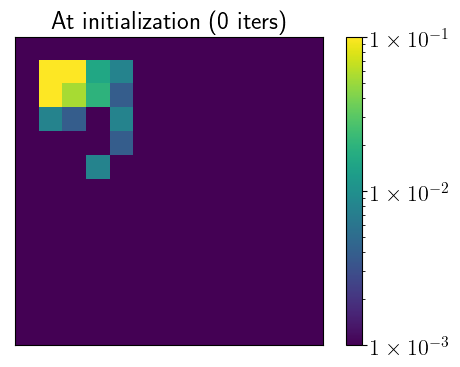

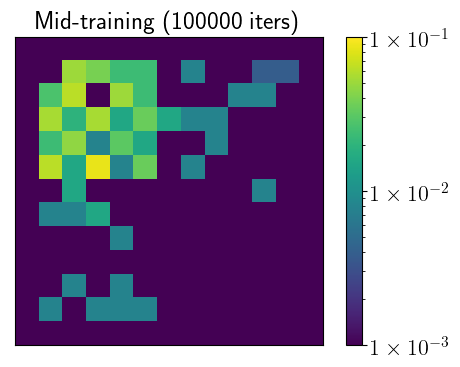

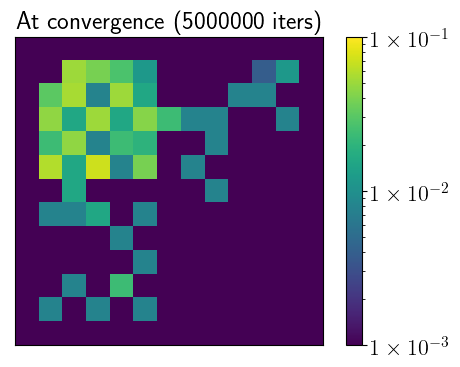

In [29]:
# log_clipping
import pickle

exp_path = '../exps/2022-12-23 06:39:38.465821/'

# init
plotdata_file = 'plotdata_100000.pkl'
plotdata_path = os.path.join(exp_path, plotdata_file)
with open(plotdata_path, 'rb') as f:
  r_plotdata = pickle.load(f)
plot_init_state_occupancies(train_config, r_plotdata.initial_state, 
                       exp_path, r_plotdata.FOUR_ROOMS_GRID_shape, r_plotdata.FOUR_ROOMS_STATES)

# mid 
plotdata_file = 'plotdata_100000.pkl'
plotdata_path = os.path.join(exp_path, plotdata_file)
with open(plotdata_path, 'rb') as f:
  r_plotdata = pickle.load(f)
title = "Mid-training"
plot_train_state_occupancies(train_config, r_plotdata.train_state, 
                               exp_path, r_plotdata.train_iterations, 
                               r_plotdata.FOUR_ROOMS_GRID_shape, r_plotdata.FOUR_ROOMS_STATES, title)

# convergence
exp_path = '../exps/2022-12-20 17:22:08.584687/'
plotdata_file = 'plotdata_5000000.pkl'
plotdata_path = os.path.join(exp_path, plotdata_file)
with open(plotdata_path, 'rb') as f:
  r_plotdata = pickle.load(f)
title = "At convergence"
plot_train_state_occupancies(train_config, r_plotdata.train_state, 
                               exp_path, r_plotdata.train_iterations, 
                               r_plotdata.FOUR_ROOMS_GRID_shape, r_plotdata.FOUR_ROOMS_STATES, title)

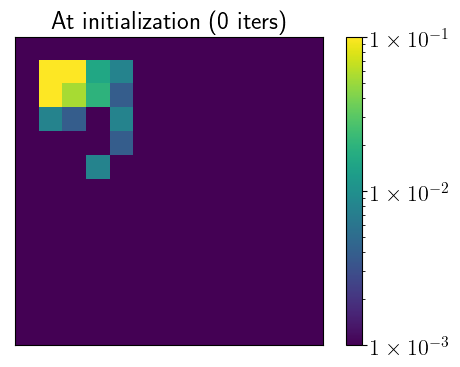

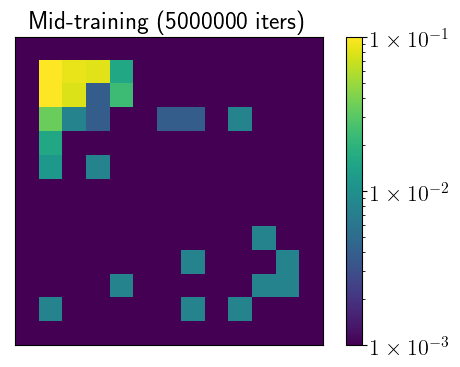

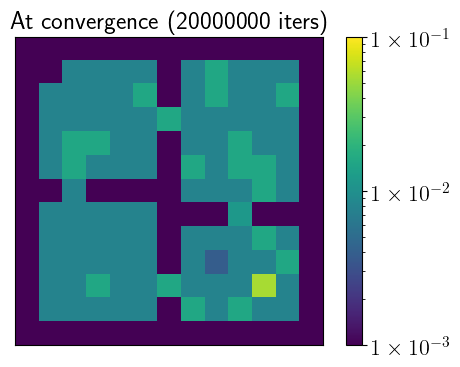

In [30]:
# disdain
import pickle

exp_path = '../exps/2022-12-22 06:49:33.576922/'

# init
plotdata_file = 'plotdata_1000000.pkl'
plotdata_path = os.path.join(exp_path, plotdata_file)
with open(plotdata_path, 'rb') as f:
  r_plotdata = pickle.load(f)
plot_init_state_occupancies(train_config, r_plotdata.initial_state, 
                       exp_path, r_plotdata.FOUR_ROOMS_GRID_shape, r_plotdata.FOUR_ROOMS_STATES)

# mid 
plotdata_file = 'plotdata_5000000.pkl'
plotdata_path = os.path.join(exp_path, plotdata_file)
with open(plotdata_path, 'rb') as f:
  r_plotdata = pickle.load(f)
title = "Mid-training"
plot_train_state_occupancies(train_config, r_plotdata.train_state, 
                               exp_path, r_plotdata.train_iterations, 
                               r_plotdata.FOUR_ROOMS_GRID_shape, r_plotdata.FOUR_ROOMS_STATES, title)

# convergence
plotdata_file = 'plotdata_20000000.pkl'
plotdata_path = os.path.join(exp_path, plotdata_file)
with open(plotdata_path, 'rb') as f:
  r_plotdata = pickle.load(f)
title = "At convergence"
plot_train_state_occupancies(train_config, r_plotdata.train_state, 
                               exp_path, r_plotdata.train_iterations, 
                               r_plotdata.FOUR_ROOMS_GRID_shape, r_plotdata.FOUR_ROOMS_STATES, title)

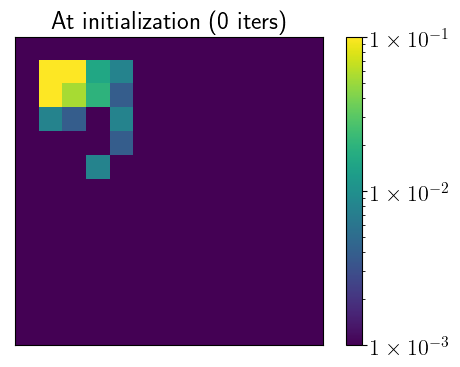

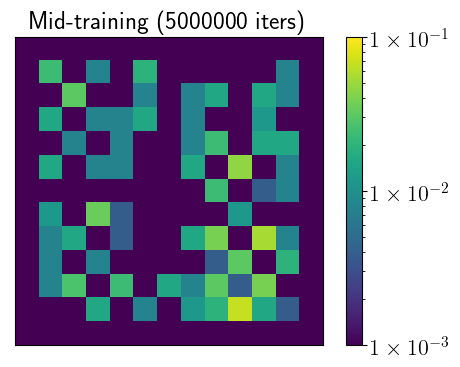

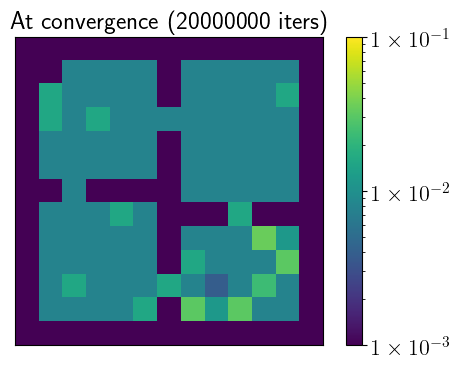

In [31]:
# linear_clipping
import pickle

exp_path = '../exps/2022-12-22 06:43:44.677475/'

# init
plotdata_file = 'plotdata_1000000.pkl'
plotdata_path = os.path.join(exp_path, plotdata_file)
with open(plotdata_path, 'rb') as f:
  r_plotdata = pickle.load(f)
plot_init_state_occupancies(train_config, r_plotdata.initial_state, 
                       exp_path, r_plotdata.FOUR_ROOMS_GRID_shape, r_plotdata.FOUR_ROOMS_STATES)

# mid 
plotdata_file = 'plotdata_5000000.pkl'
plotdata_path = os.path.join(exp_path, plotdata_file)
with open(plotdata_path, 'rb') as f:
  r_plotdata = pickle.load(f)
title = "Mid-training"
plot_train_state_occupancies(train_config, r_plotdata.train_state, 
                               exp_path, r_plotdata.train_iterations, 
                               r_plotdata.FOUR_ROOMS_GRID_shape, r_plotdata.FOUR_ROOMS_STATES, title)

# convergence
plotdata_file = 'plotdata_20000000.pkl'
plotdata_path = os.path.join(exp_path, plotdata_file)
with open(plotdata_path, 'rb') as f:
  r_plotdata = pickle.load(f)
title = "At convergence"
plot_train_state_occupancies(train_config, r_plotdata.train_state, 
                               exp_path, r_plotdata.train_iterations, 
                               r_plotdata.FOUR_ROOMS_GRID_shape, r_plotdata.FOUR_ROOMS_STATES, title)